In [ ]:
import pyspark
from pyspark.sql import SparkSession
import requests
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [21]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Time Series Linear Regression") \
    .getOrCreate()

In [22]:
# URL of the cleaned data (you can replace this with the path to your dataset)
url = "https://raw.githubusercontent.com/natbiorg/project_4/refs/heads/main/Starter_Code/Resources/cleaned.csv"


In [23]:
# Path to save the CSV locally (in Colab, it will be saved under /content/)
local_file_path = "/content/cleaned.csv"

# Download the file
response = requests.get(url)
with open(local_file_path, 'wb') as file:
    file.write(response.content)

print(f"File downloaded to {local_file_path}")

File downloaded to /content/cleaned.csv


In [24]:
# Read the CSV file into a PySpark DataFrame
df = spark.read.csv("/content/cleaned.csv", sep=",", header=True, inferSchema=True)

df.show(5)

+-----------+------+-------------+--------------+----------------+--------------+--------------------+------------------+--------+-------------+----------------+-------------+---+-------------+------------+-----+-----------+-------------------+--------------+--------+-----------+-----------------+------------------+
|Customer_ID|Gender|Tenure_Months|Transaction_ID|Transaction_Date|   Product_SKU| Product_Description|  Product_Category|Quantity|Average_Price|Delivery_Charges|Coupon_Status|GST|Offline_Spend|Online_Spend|Month|Coupon_Code|Discount_Percentage|  Near_Holiday|   State|Total_Sales|       Total_Cost|  Average_Saved($)|
+-----------+------+-------------+--------------+----------------+--------------+--------------------+------------------+--------+-------------+----------------+-------------+---+-------------+------------+-----+-----------+-------------------+--------------+--------+-----------+-----------------+------------------+
|    17850.0|     M|         12.0|       16679

In [25]:
# Convert the PySpark DataFrame to Pandas
pandas_df = df.toPandas()

# Display the first few rows
pandas_df.head()

,Customer_ID,Gender,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Average_Price,...,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_Percentage,Near_Holiday,State,Total_Sales,Total_Cost,Average_Saved($)
0,17850.0,M,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest Smart Devices,1.0,153.71,...,4500.0,2424.5,1,ELEC10,10.0,New Year's Day,Illinois,153.71,144.839,15.371
1,17850.0,M,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest Smart Devices,1.0,153.71,...,4500.0,2424.5,1,ELEC10,10.0,New Year's Day,Illinois,153.71,144.839,15.371
2,17850.0,M,12.0,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest Smart Devices,2.0,122.77,...,4500.0,2424.5,1,ELEC10,10.0,New Year's Day,Illinois,245.54,227.486,12.277
3,17850.0,M,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest Smart Devices,1.0,81.50,...,4500.0,2424.5,1,ELEC10,10.0,New Year's Day,Illinois,81.50,79.850,8.150
4,17850.0,M,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest Smart Devices,1.0,153.71,...,4500.0,2424.5,1,ELEC10,10.0,New Year's Day,Illinois,153.71,144.839,15.371


In [75]:
# Define independent (X) and dependent (y) variables for time series modeling
# Using 'Total_Cost' as the independent variable and 'Total_Sales' as the dependent variable
time_series = pandas_df['Total_Cost'].values
target_series = pandas_df['Total_Sales'].values

In [76]:
window_size = 1
X, y = [], []
for i in range(len(time_series) - window_size):
    X.append(time_series[i:i + window_size])
    y.append(target_series[i + window_size])

In [77]:
# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [79]:
# Make predictions
predictions = model.predict(X_test)
print("Predictions:", predictions)

Predictions: [ 64.41536572  61.14841352 182.55396514 ...  68.21102019  61.37265357
  92.44155235]


In [80]:
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

R-squared: 0.11913638203131027


In [ ]:
#Plot

In [81]:
# Print the model's slope and intercept
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

Slope: 0.3820103132305917
Intercept: 57.52198961663803


Text(0.05, 0.9, 'Intercept: 57.52')

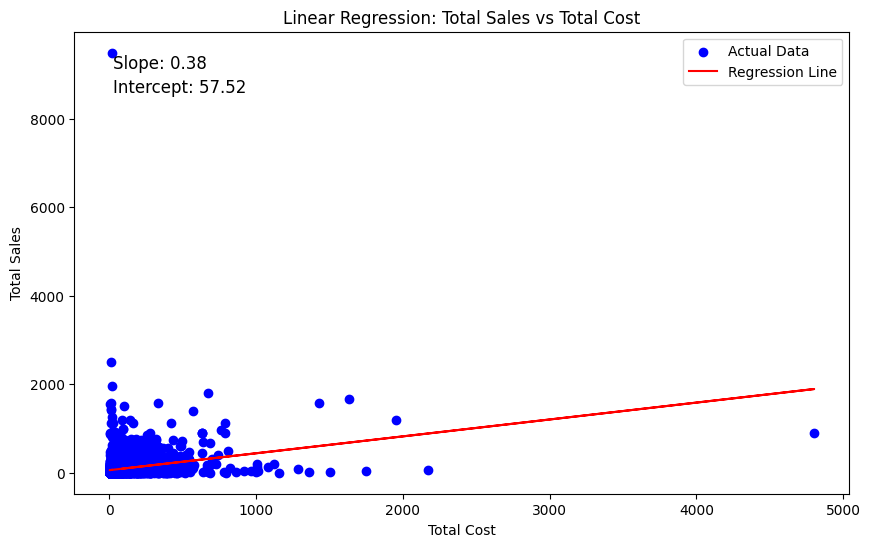

In [84]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, predictions, color='red', label='Regression Line')
plt.xlabel('Total Cost')
plt.ylabel('Total Sales')
plt.title('Linear Regression: Total Sales vs Total Cost')
slope = model.coef_[0]
intercept = model.intercept_
plt.legend()

plt.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f"Intercept: {intercept:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
